In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from torch import nn, optim
from torch.functional import F
from torch.utils.data import DataLoader
from torchvision import transforms, datasets

%config IPCompleter.greedy = True

In [30]:
# download FashionMNIST dataset

datasets.FashionMNIST.resources = [
    ("http://kleshwong.com/download/train-images-idx3-ubyte.gz",
     "8d4fb7e6c68d591d4c3dfef9ec88bf0d"),
    ("http://kleshwong.com/download/train-labels-idx1-ubyte.gz",
     "25c81989df183df01b3e8a0aad5dffbe"),
    ("http://kleshwong.com/download/t10k-images-idx3-ubyte.gz",
     "bef4ecab320f06d8554ea6380940ec79"),
    ("http://kleshwong.com/download/t10k-labels-idx1-ubyte.gz",
     "bb300cfdad3c16e7a12a480ee83cd310")
]

train_set = datasets.FashionMNIST(
    root="./data",
    download=True,
    train=True,
    transform=transforms.Compose([
        transforms.ToTensor()
    ])
)

test_set = datasets.FashionMNIST(
    root="./data",
    download=True,
    train=False,
    transform=transforms.Compose([
        transforms.ToTensor()
    ])
)

train_set.classes

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

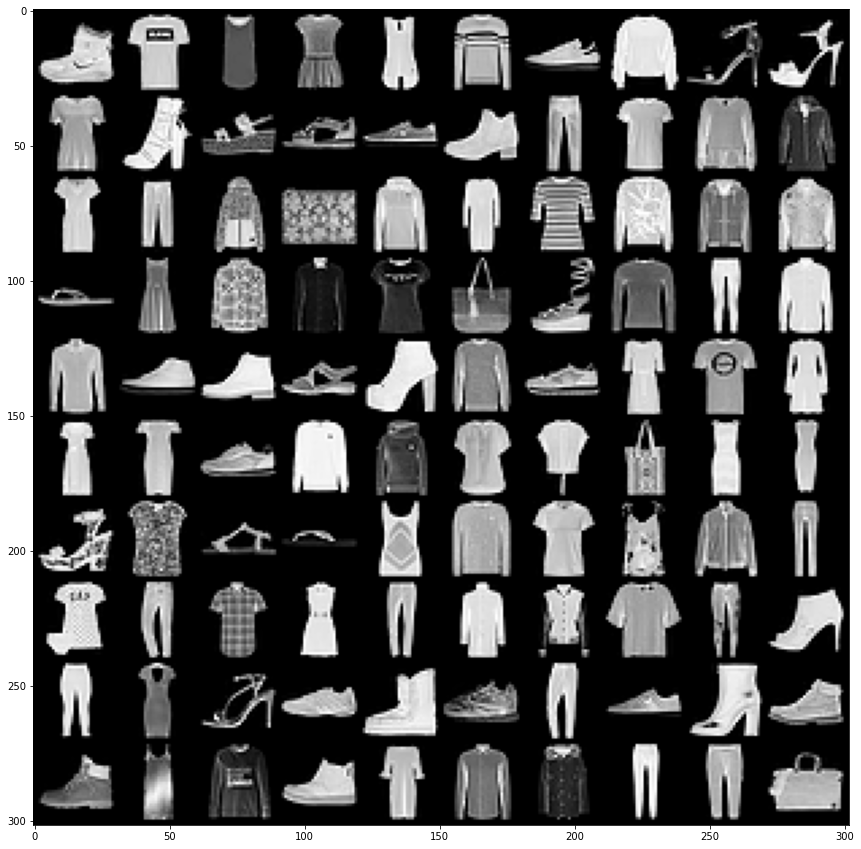

In [3]:
# observing dataset

images, labels = next(iter(DataLoader(train_set, batch_size=100)))

grid = torchvision.utils.make_grid(images, nrow=10)

plt.figure(figsize=(15, 15))
plt.imshow(np.transpose(grid, (1, 2, 0)))

In [20]:
# define network
class Network(nn.Module):
    
    def __init__(self, kernel_size=5):
        super().__init__()
        self.pool_stride = (2, 2)
        w = h = 28
        o = lambda n, f, p, s: (n - f + 2*p) // s + 1
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=kernel_size)
        w = o(w, kernel_size, 0, self.pool_stride[0])
        h = o(h, kernel_size, 0, self.pool_stride[1])
        
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=kernel_size)
        w = o(w, kernel_size, 0, self.pool_stride[0])
        h = o(h, kernel_size, 0, self.pool_stride[1])
        
        self.fc1 = nn.Linear(in_features=12*w*h, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=60)
        self.out = nn.Linear(in_features=60, out_features=10)
        
        self.w = w
        self.h = h
        
    def forward(self, x):
        # conv layer #1
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        
        # conv layer #2
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        
        # linear layer #1
        x = x.reshape(-1, 12*self.w*self.h)
        x = self.fc1(x)
        x = F.relu(x)
        
        # linear layer #2
        x = self.fc2(x)
        x = F.relu(x)
        
        # output layer
        x = self.out(x)
        
        return x
    
network = Network(kernel_size=3)
print('networ', network)
for name, param in network.named_parameters():
    print(name, '\t\t', param.shape)

networ Network(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 12, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=432, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=60, bias=True)
  (out): Linear(in_features=60, out_features=10, bias=True)
)
conv1.weight 		 torch.Size([6, 1, 3, 3])
conv1.bias 		 torch.Size([6])
conv2.weight 		 torch.Size([12, 6, 3, 3])
conv2.bias 		 torch.Size([12])
fc1.weight 		 torch.Size([120, 432])
fc1.bias 		 torch.Size([120])
fc2.weight 		 torch.Size([60, 120])
fc2.bias 		 torch.Size([60])
out.weight 		 torch.Size([10, 60])
out.bias 		 torch.Size([10])


In [5]:
# epoch

def epoch(epoch_id, network, optimizer, loader, run):
    total_loss = 0
    total_correct = 0
    for images, labels in loader:
        images = images.cuda()
        labels = labels.cuda()
        preds = network(images)
        loss = F.cross_entropy(preds, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        with torch.no_grad():
            total_loss += loss.item()
            total_correct += preds.argmax(dim=1).eq(labels).sum().item()
    return total_loss, total_correct


In [33]:
# finding hyper parameters

from collections import namedtuple, OrderedDict
from itertools import product
from torch.utils.tensorboard import SummaryWriter

epoch_num = 5
hyper_params = OrderedDict(
    batch_size=[64, 128],
    lr=[0.001, 0.01],
)

Run = namedtuple('Run', hyper_params.keys())
runs = [Run(*values) for values in product(*hyper_params.values())]


# loop through all combinations
for run in runs:
    network = Network().cuda()
    optimizer = optim.Adam(network.parameters(), lr=run.lr)
    loader = DataLoader(train_set, batch_size=run.batch_size, shuffle=True, num_workers=1)
    images, labels = next(iter(loader))
    images = images.cuda()
    writer = SummaryWriter(f'runs/fashion_mnist_exp/batch_size_{run.batch_size}_lr_{run.lr}')
    writer.add_image('image', torchvision.utils.make_grid(images))
    writer.add_graph(network, images)
    for epoch_id in range(epoch_num):
        total_loss, total_correct = epoch(epoch_id, network, optimizer, loader, run)
        run_data.append([epoch_id, total_loss, total_correct])
        print(f'{run}\t epoch {epoch_id}\t loss: {total_loss}\t accuracy: {total_correct/len(train_set)}')
        writer.add_scalar('Total loss', total_loss, epoch_id)
        writer.add_scalar('Accuracy', total_correct/len(train_set), epoch_id)
    writer.close()


Run(batch_size=64, lr=0.001)	 epoch 0	 loss: 710.201931655407	 accuracy: 0.7087333333333333
Run(batch_size=64, lr=0.001)	 epoch 1	 loss: 475.59671591222286	 accuracy: 0.8101
Run(batch_size=64, lr=0.001)	 epoch 2	 loss: 394.83101566135883	 accuracy: 0.8474666666666667
Run(batch_size=64, lr=0.001)	 epoch 3	 loss: 347.85421738773584	 accuracy: 0.8646833333333334
Run(batch_size=64, lr=0.001)	 epoch 4	 loss: 320.0938688144088	 accuracy: 0.8739
Run(batch_size=64, lr=0.01)	 epoch 0	 loss: 506.8984014093876	 accuracy: 0.7949333333333334
Run(batch_size=64, lr=0.01)	 epoch 1	 loss: 366.27826349437237	 accuracy: 0.85515
Run(batch_size=64, lr=0.01)	 epoch 2	 loss: 332.80006838589907	 accuracy: 0.86825
Run(batch_size=64, lr=0.01)	 epoch 3	 loss: 322.96275720000267	 accuracy: 0.8723666666666666
Run(batch_size=64, lr=0.01)	 epoch 4	 loss: 317.37463522702456	 accuracy: 0.8765833333333334
Run(batch_size=128, lr=0.001)	 epoch 0	 loss: 408.5632227063179	 accuracy: 0.6710666666666667
Run(batch_size=128, l

In [10]:
train_set[0]

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0000, 0.0000, 0.0510,
           0.2863, 0.0000, 0.0000, 0.0039, 